In [1]:
import os
import sys
import cv2
from matplotlib import pyplot as plt
import sys
import json
import numpy as np
import base64
import face_alignment
from PIL import Image, ImageDraw

from masked_face_sdk.utils import \
(
    extract_target_points_and_characteristic, 
    extract_polygon,
    rotate_image_and_points,
    draw_landmarks,
    warp_mask,
    get_traingulation_mesh_points_indexes,
    end2end_mask_generation
)


%matplotlib inline

In [2]:
# Generate masks database
# !python3 generate_masks_database.py --masks-folder=data/masked_faces/ --database-file=data/masks_base.json

In [3]:
# Generate landmark estimator by face_alignment library
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device='cpu')

-9.66395432628186 0.6825933417201632


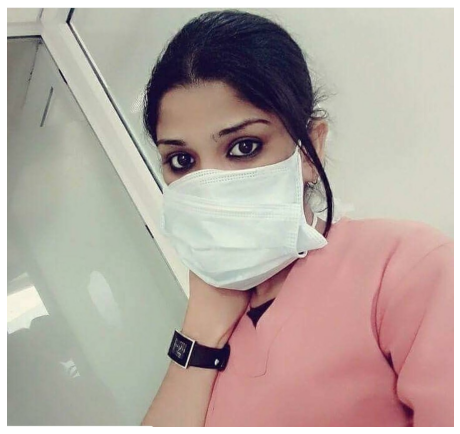

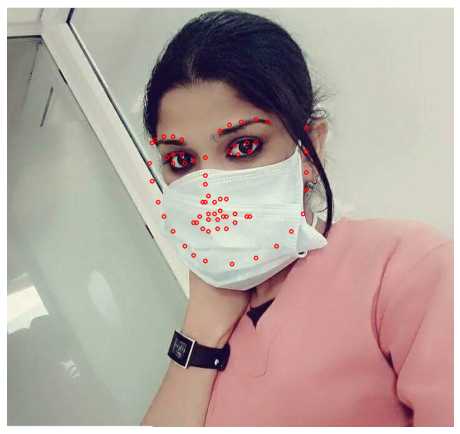

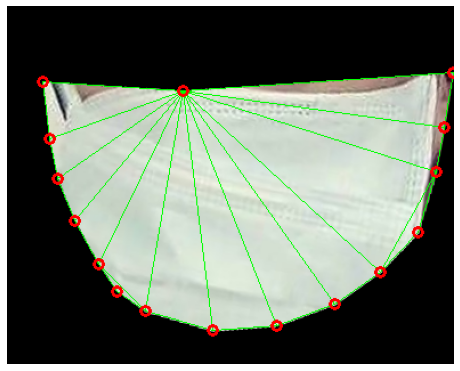

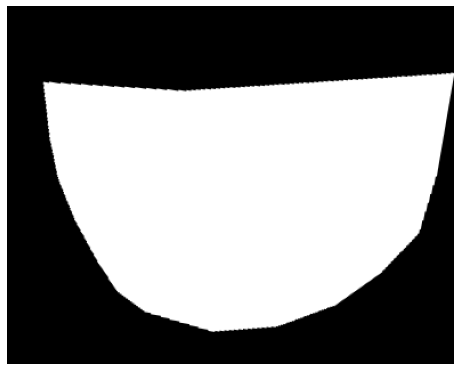

In [4]:
masked_faces_images_pathes = [
    os.path.join('data/masked_faces/', img_name)
    for img_name in os.listdir('data/masked_faces/')
]

example_image = cv2.cvtColor(
    cv2.imread(
        masked_faces_images_pathes[19]
    ), 
    cv2.COLOR_BGR2RGB
)

landmarks = fa.get_landmarks_from_image(example_image)
landmarks = np.floor(landmarks[0]).astype(np.int32)

plt.figure(figsize=(8, 8))
plt.imshow(example_image)
plt.axis('off')

plt.figure(figsize=(8, 8))
plt.imshow(draw_landmarks(example_image, landmarks, color=(255, 0, 0), thickness=4))
plt.axis('off')

target_points, s1, s2 = extract_target_points_and_characteristic(landmarks)
mask_rgba_crop, target_points = extract_polygon(example_image, target_points)

print(s1, s2)

mask_rgba_crop, target_points = rotate_image_and_points(mask_rgba_crop, s1, target_points)

triangles_indexes = get_traingulation_mesh_points_indexes(target_points)

mask_rgba_crop_vis = mask_rgba_crop[..., :3].copy().astype(np.uint8)
for triangle in triangles_indexes:
    triangle_points = target_points[triangle]
    
    mask_rgba_crop_vis = cv2.line(
        mask_rgba_crop_vis,
        tuple(triangle_points[0]),
        tuple(triangle_points[1]),
        (0, 255, 0),
        1
    )
    
    mask_rgba_crop_vis = cv2.line(
        mask_rgba_crop_vis,
        tuple(triangle_points[1]),
        tuple(triangle_points[2]),
        (0, 255, 0),
        1
    )
    
    mask_rgba_crop_vis = cv2.line(
        mask_rgba_crop_vis,
        tuple(triangle_points[0]),
        tuple(triangle_points[2]),
        (0, 255, 0),
        1
    )

plt.figure(figsize=(8, 8))
plt.imshow(draw_landmarks(mask_rgba_crop_vis, target_points, color=(255, 0, 0), thickness=4))
plt.axis('off')

plt.figure(figsize=(8, 8))
plt.imshow(mask_rgba_crop[..., 3], 'gray')
plt.axis('off')


plt.show()

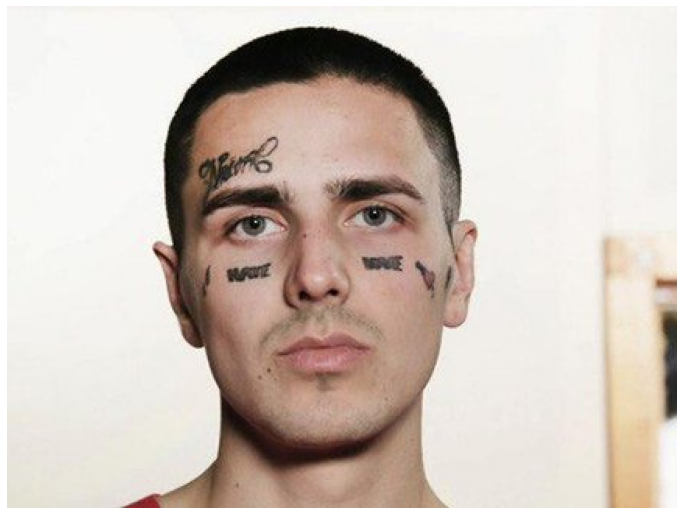

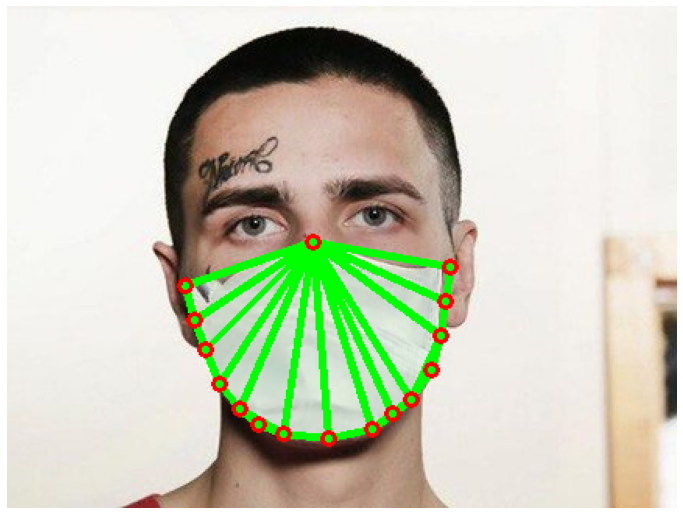

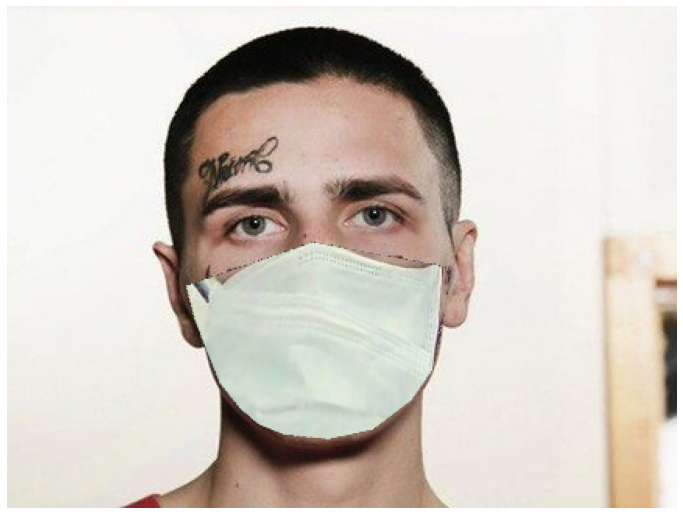

In [5]:
target_image = cv2.cvtColor(
    cv2.imread(
        'data/map.jpg', 
        cv2.IMREAD_COLOR
    ),
    cv2.COLOR_BGR2RGB
)

landmarks2 = fa.get_landmarks_from_image(target_image)
landmarks2 = np.floor(landmarks2[0]).astype(np.int32)

target_points2, _, _ = extract_target_points_and_characteristic(landmarks2)

target_image_with_mask = warp_mask(
    mask_rgba_crop[..., :3],
    target_image,
    target_points,
    target_points2
)


# triangles_indexes = get_traingulation_mesh_points_indexes(target_points2)

mask_rgba_crop_vis = target_image_with_mask.copy().astype(np.uint8)
for triangle in triangles_indexes:
    triangle_points = target_points2[triangle]
    
    mask_rgba_crop_vis = cv2.line(
        mask_rgba_crop_vis,
        tuple(triangle_points[0]),
        tuple(triangle_points[1]),
        (0, 255, 0),
        3
    )
    
    mask_rgba_crop_vis = cv2.line(
        mask_rgba_crop_vis,
        tuple(triangle_points[1]),
        tuple(triangle_points[2]),
        (0, 255, 0),
        3
    )
    
    mask_rgba_crop_vis = cv2.line(
        mask_rgba_crop_vis,
        tuple(triangle_points[0]),
        tuple(triangle_points[2]),
        (0, 255, 0),
        3
    )


plt.figure(figsize=(12, 12))
plt.imshow(target_image)
plt.axis('off')

plt.figure(figsize=(12, 12))
plt.imshow(draw_landmarks(mask_rgba_crop_vis, target_points2, color=(255, 0, 0), thickness=4))
plt.axis('off')

plt.figure(figsize=(12, 12))
plt.imshow(target_image_with_mask)
plt.axis('off')
plt.show()

In [6]:
with open('data/masks_base.json', 'r') as jf:
    masks_database = json.load(jf)

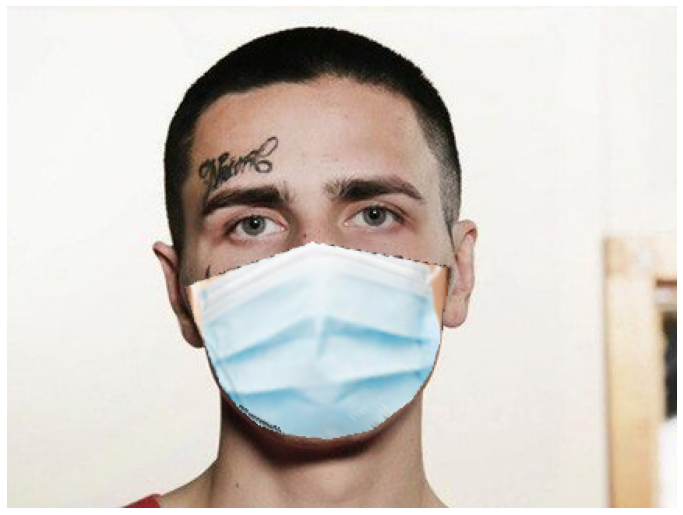

In [7]:
target_image_with_mask = end2end_mask_generation(target_image, masks_database, fa)

plt.figure(figsize=(12, 12))
plt.imshow(target_image_with_mask)
plt.axis('off')
plt.show()